In [2]:
##爬虫
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import html2text
from atlassian import Confluence
import tiktoken
import pandas as pd
import openai
from openai.embeddings_utils import distances_from_embeddings
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity
import time


# set your confluence account and space key
domain = "confluence.xxx.com"
full_url = "https://confluence.xxxx.com/"
user_name = "xxxxxxx"
password = "xxxx"

space_key = "xxxxx"
##Data saving address, please customize
filePath = "/Users/xxxx/text/"
processPath = "/Users/xxxxx/processed/"

##Separators and replacements, mainly for file name generation and title reduction
splitFlag = "$"
replaceFlag = "_"




##Setting up the openai 
openai.organization = ""
openai.api_key = ""

ModuleNotFoundError: No module named 'html2text'

In [2]:
def crawler(base_url,username,password,space_key,totalSpace = False):
    confluence = Confluence(url=base_url, username=username, password=password)
    ##待实现，爬取所有的space
    ##获取对应空间
    space = confluence.get_space(space_key, expand='description.plain,homepage')
    ##获取space页面id
    page_id = space["homepage"]["id"]
    
        # Create a directory to store the text files
    if not os.path.exists(filePath):
            os.mkdir(filePath)

    # Create a directory to store the csv files
    if not os.path.exists(processPath):
            os.mkdir(processPath)
    
    ##子页面
    child = confluence.get_page_child_by_type(page_id, type='page', start=None, limit=None, expand=None)
    
    ##初始化队列
    queue = deque()
    for i in child:
        queue.append(i)
    
    while queue:
        # Get the next URL from the queue
        childPage = queue.pop()
        ##拿到页面id
        html = confluence.get_page_by_id(childPage["id"], expand="body.storage")
        # 调用方法，将html转为纯文本
        content = html["body"]["storage"]["value"]
        content_text = html2text.html2text(content)
        
        ##文本不为空写入
        if content_text.lstrip() != "":
            title = str(html["title"]).replace("/",replaceFlag)
    #         if not os.path.exists("/Users/lei.zhou/text/"+html["title"]):
    #             os.mkdir("/Users/lei.zhou/text/")
            with open(filePath+ childPage["id"]+splitFlag+title+ ".txt", "w") as f:
                f.write(content_text)

        ##加入子节点‘
        for i in confluence.get_page_child_by_type(childPage["id"], type='page', start=None, limit=None, expand=None):
            queue.append(i)


In [24]:
max_tokens = 500

def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    寻找最相似的文本段
    """
    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # 使用余弦算法计算最相似的文本
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # 不断添加文本到上限
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # 文本创建
        cur_len += row['n_tokens'] + 4
        
        # 超出上限退出
        if cur_len > max_len:
            break
        
        # 增加文本
        returns.append(row["text"])

    # 返回
    return "\n\n###\n\n".join(returns)


# token分割
def split_into_many(text, max_tokens = max_tokens):

    # 定义分割符号，可以允许自定义
    sentences = re.split('[.。！？!?]',text)

    # 获取每段的token
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # 遍历
    for sentence, token in zip(sentences, n_tokens):

        # 如果到目前为止的标记数量加上当前句子中的标记数量大于,大于最大标记数，则将该块添加到块的列表中，并重置到目前为止的块和标记数
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

    
        if token > max_tokens:
            continue

        # 添加
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


##数据，模型，问题，长度，
def answer_question(
    df,
    model="text-davinci-003",
    question="你有什么问题",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=1800,
    stop_sequence=None,
    use_GPT=False
):
    """
    回答问题
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")
        print(f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:")
    if use_GPT:
        completion = openai.ChatCompletion.create(model="gpt-3.5-turbo",messages=[
    {"role": "user", "content": f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:"}])
        return completion.to_dict()["choices"][0]["message"]["content"]
    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

    

In [153]:
crawler(base_url,username,password,space_key)

SSLError: HTTPSConnectionPool(host='confluence.maezia.com', port=443): Max retries exceeded with url: /rest/api/content/142206964?expand=body.storage (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)')))

In [9]:
#原始文本
texts=[]

# 遍历
for file in os.listdir(filePath):
    # 文件读取
    with open(filePath+file, "r") as f:
        titles = file.split(splitFlag)
        if len(titles) <= 1:
            continue
        title = titles[1]
        text = f.read()
        # 标题还原，把_替换为空格插入
        texts.append((title.replace(replaceFlag," "), text))
        
# pd创建
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# 按行分段
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

NameError: name 'filePath' is not defined

In [8]:
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

df

NameError: name 'tiktoken' is not defined

<AxesSubplot:>

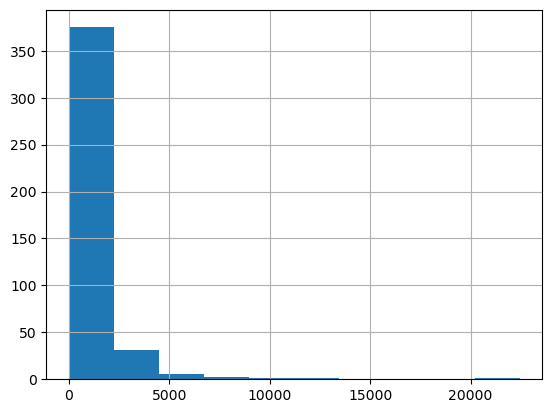

In [12]:
# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

<AxesSubplot:>

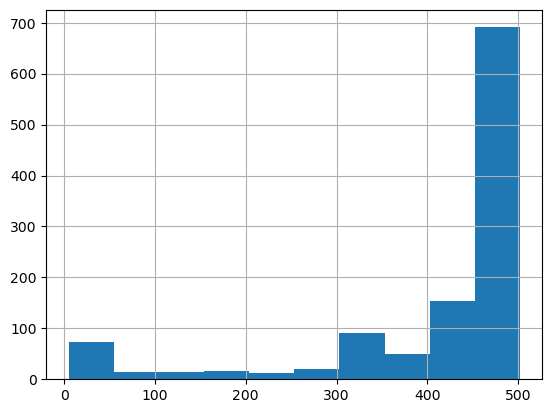

In [13]:
shortened = []

# 循环减少文本
for row in df.iterrows():
    print(row)

    if row[1]['text'] is None:
        continue

    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    else:
        shortened.append( row[1]['text'] )
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [7]:
##由于官方的限制，1分钟最多发起60个请求，所以为了防止报错此处主动休眠
##由于数据量过大，如果无法运行，可以在上面一栏    截取部分数据df = df[0:x]  x为截取长度
def cal(x,waittime = 0.6):
    res = openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding']
    time.sleep(waittime)
    return res
df['embeddings'] = df.text.apply(lambda x: cal(x))

df.to_csv('processed/embeddings.csv')
df.head()

NameError: name 'df' is not defined

In [6]:
##读取token数据
df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()

NameError: name 'pd' is not defined

In [3]:
##输入最大token，返回长度进行提问
answer_question(df, question="", debug=False,use_GPT=True,max_len=1800,max_tokens = 1800)

NameError: name 'answer_question' is not defined

In [4]:
answer_question(df, question="", debug=False,use_GPT=True,max_len=1800,max_tokens = 1800)

NameError: name 'answer_question' is not defined

In [5]:
answer_question(df, question="", debug=False,use_GPT=True,max_len=1800,max_tokens = 1800)

NameError: name 'answer_question' is not defined